  0%|                                                          | 0/2 [00:00<?, ?it/s]

 computing backazimuth estimation
attempt to get argmax of an empty sequence
 -> baz computation failed!
 computing beamforming
 -> obtained: 9 of 9 stations!


 50%|█████████████████████████                         | 1/2 [00:11<00:11, 11.77s/it]


 -> Runtime: 0.12 minutes
359 359
type numpy.ndarray doesn't define __round__ method
 -> beamforming computation failed!
 computing backazimuth estimation
 -> stored: /home/andbro/kilauea-data/VelocityChanges/figures/autoplots/VC_BAZ_2023-09-20_21:30:00_2023-09-20_22:00:00.png
 computing beamforming
 -> obtained: 9 of 9 stations!


100%|██████████████████████████████████████████████████| 2/2 [00:55<00:00, 27.87s/it]


 -> Runtime: 0.14 minutes
359 359
type numpy.ndarray doesn't define __round__ method
 -> beamforming computation failed!
-> store: /home/andbro/kilauea-data/VelocityChanges/data/statistics/VC_BAZ_2023-09-20.pkl
-> store: /home/andbro/kilauea-data/VelocityChanges/data/all/VC_BAZ_2023-09-20_all.pkl
 -> stored: /home/andbro/kilauea-data/VelocityChanges/figures/autoplots/status/VC_BAZ_2023-09-20.png




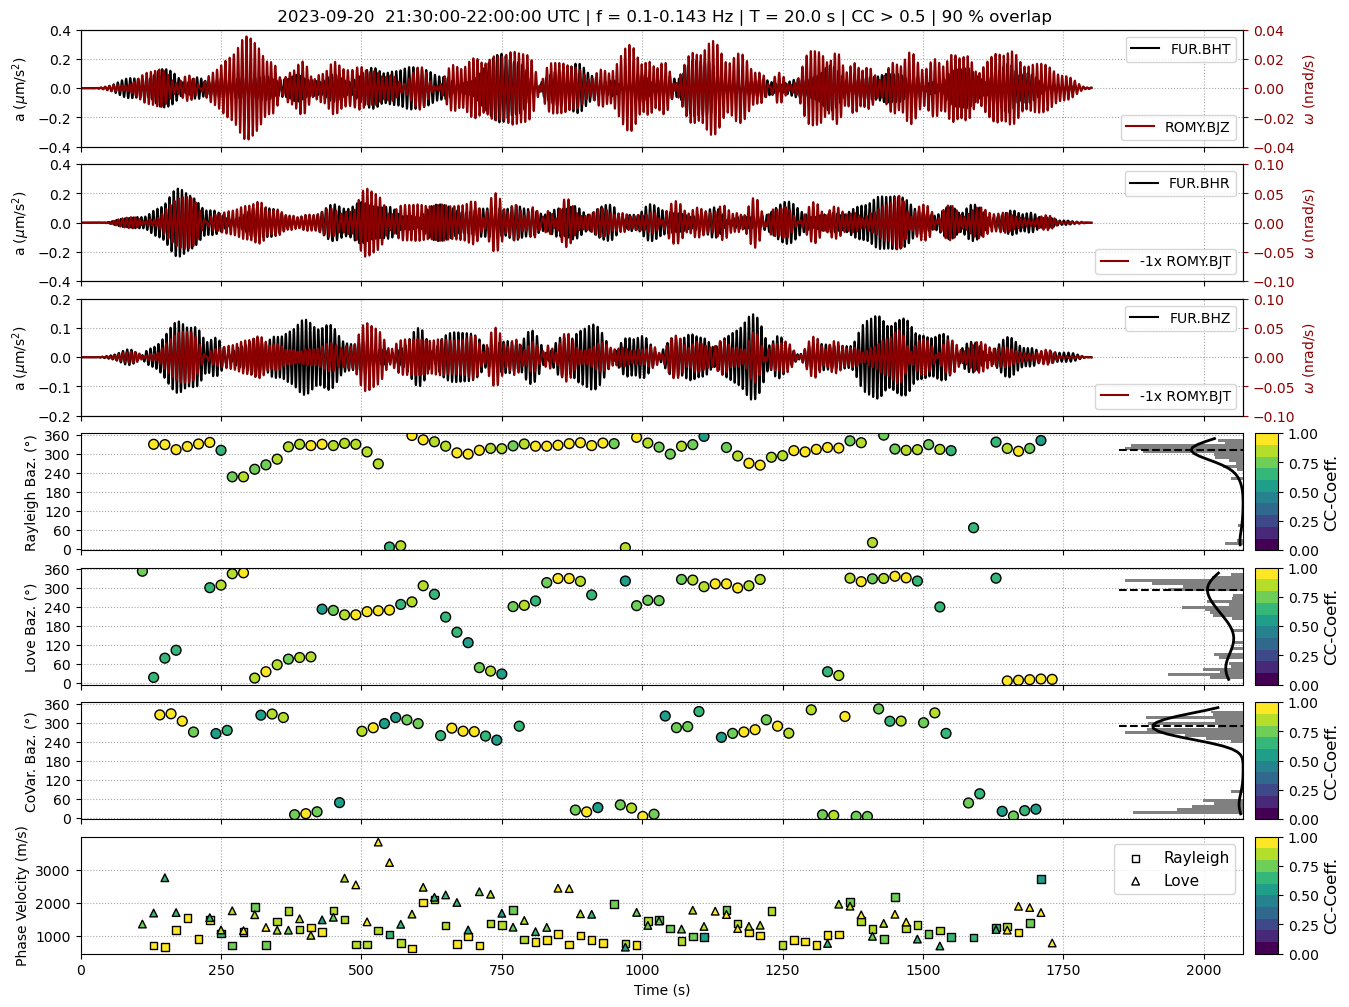

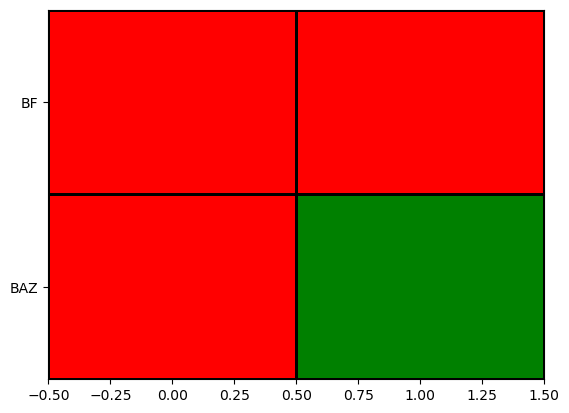

In [6]:
#!/bin/python3

import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from obspy import UTCDateTime, read_inventory

from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.get_time_intervals import __get_time_intervals
from functions.compute_beamforming_ROMY import __compute_beamforming_ROMY
from functions.compute_backazimuth_and_velocity_noise import __compute_backazimuth_and_velocity_noise

from andbro__read_sds import __read_sds
from andbro__save_to_pickle import __save_to_pickle

## ---------------------------------------


if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'


## ---------------------------------------

config = {}

# config['station1'] = "BW.ROMY.10.BJZ"
# config['station2'] = "GR.FUR..BHN"

# if len(sys.argv) > 1:
#     config['tbeg'] = UTCDateTime(sys.argv[1])
#     config['tend'] = config['tbeg'] + 86400

config['tbeg'] = UTCDateTime("2023-09-20 21:00")
config['tend'] = UTCDateTime("2023-09-20 22:00")

config['path_to_sds1'] = archive_path+"romy_archive/"

config['path_to_sds2'] = bay_path+f"mseed_online/archive/"

config['path_to_figures'] = data_path+f"VelocityChanges/figures/autoplots/"

config['path_to_inv'] = root_path+"Documents/ROMY/stationxml_ringlaser/"

config['path_to_data_out'] = data_path+f"VelocityChanges/data/"

## set maximum number of MLTI in time interval. Otherwise skip interval.
config['num_mlti'] = 3

config['fmin'], config['fmax'] = 1/10, 1/7

config['cc_threshold'] = 0.5

config['interval_seconds'] = 1800

config['window_overlap'] = 90

config['window_length_sec'] = 2/config['fmin']

## ---------------------------------------

def __load_mlti(tbeg, tend, ring, path_to_archive):

    from obspy import UTCDateTime
    from pandas import read_csv

    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    year = tbeg.year

    rings = {"U":"03", "Z":"01", "V":"02", "W":"04"}

    path_to_mlti = path_to_archive+f"romy_archive/{year}/BW/CROMY/{year}_romy_{rings[ring]}_mlti.log"

    mlti = read_csv(path_to_mlti, names=["time_utc","Action","ERROR"])

    mlti = mlti[(mlti.time_utc > tbeg) & (mlti.time_utc < tend)]

    return mlti

## ---------------------------------------

times = __get_time_intervals(config['tbeg'], config['tend'], interval_seconds=config['interval_seconds'], interval_overlap=0)

baz_tangent = []
baz_rayleigh = []
baz_love = []

baz_tangent_std = []
baz_rayleigh_std = []
baz_love_std = []

baz_tangent_all = []
baz_rayleigh_all = []
baz_love_all = []
baz_bf_all = []

cc_tangent_all = []
cc_rayleigh_all = []
cc_love_all = []

vel_love_max = []
vel_love_std = []
vel_rayleigh_max = []
vel_rayleigh_std = []

vel_rayleigh_all = []
vel_love_all = []
vel_bf_all = []

times_relative = []
times_all = []

baz_bf = []
baz_bf_std = []

vel_bf = []
time_bf = []

ttime = []

num_stations_used = []

status = np.zeros((2, len(times)))

nan_dummy = np.ones(90)*np.nan

for _n, (t1, t2) in enumerate(tqdm(times)):

    mltiU = __load_mlti(t1, t2, "U", archive_path)
    mltiV = __load_mlti(t1, t2, "V", archive_path)
    mltiZ = __load_mlti(t1, t2, "Z", archive_path)

    try:
        # inv1 = read_inventory(config['path_to_inv']+"dataless/dataless.seed.BW_ROMY")
        # inv2 = read_inventory(config['path_to_inv']+"dataless/dataless.seed.GR_FUR")

        inv1 = read_inventory(config['path_to_inv']+"station_BW_ROMY.xml")
        inv2 = read_inventory(config['path_to_inv']+"station_GR_FUR.xml")

        st1 =  __read_sds(config['path_to_sds1'], "BW.ROMY.10.BJZ", t1, t2);
        st1 += __read_sds(config['path_to_sds1'], "BW.ROMY..BJU", t1, t2);
        st1 += __read_sds(config['path_to_sds1'], "BW.ROMY..BJV", t1, t2);


        st2 =  __read_sds(config['path_to_sds2'], "GR.FUR..BHZ", t1, t2);
        st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHN", t1, t2);
        st2 += __read_sds(config['path_to_sds2'], "GR.FUR..BHE", t1, t2);

        st1.remove_sensitivity(inv1);
        st2.remove_response(inv2, output="ACC", water_level=60);

        levels = {}
        for tr in st1:
            ring = tr.stats.channel[-1]
            levels[ring] = np.percentile(abs(tr.data), 90)

        st1 = __rotate_romy_ZUV_ZNE(st1, inv1);

    except:
        print(f" -> data loading failed !")
        pass

## ---------------------------------------

    try:
        st1.detrend("linear");
        st2.detrend("linear");

        acc = st2.copy();
        rot = st1.copy();

        acc = acc.detrend("linear");
        acc = acc.taper(0.01);
        acc = acc.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True);

        rot = rot.detrend("linear");
        rot = rot.taper(0.01);
        rot = rot.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=8, zerophase=True);

    except:
        print(f" -> processing failed !")
        pass

## ---------------------------------------

    conf = {}

    conf['eventtime'] = config['tbeg']

    conf['tbeg'] = t1
    conf['tend'] = t2

    conf['station_longitude'] = 11.275501
    conf['station_latitude']  = 48.162941

    ## specify window length for baz estimation in seconds
    conf['win_length_sec'] = config['window_length_sec']

    ## define an overlap for the windows in percent (50 -> 50%)
    conf['overlap'] = config['window_overlap']

    ## specify steps for degrees of baz
    conf['step'] = 1

    conf['path_to_figs'] = config['path_to_figures']

    conf['cc_thres'] = config['cc_threshold']

    try:
        print(f" computing backazimuth estimation")
        out = __compute_backazimuth_and_velocity_noise(conf, rot, acc, config['fmin'], config['fmax'], plot=False, save=True);


        if mltiU.size > config['num_mlti'] or mltiV.size > config['num_mlti'] or levels["U"] > 1e-6 or levels["V"] > 1e-6:
            print(" -> to many MLTI (horizontal)")

            out['baz_tangent_max'], out['baz_tangent_std'], out['baz_tangent_all'] = np.nan, np.nan, nan_dummy

            out['baz_rayleigh_max'], out['baz_rayleigh_std'], out['baz_rayleigh_all'] = np.nan, np.nan, nan_dummy

            out['vel_rayleigh_max'], out['vel_rayleigh_std'], out['vel_rayleigh_all'] = np.nan, np.nan, nan_dummy

            out['cc_rayleigh_all'], out['cc_tangent_all'] = nan_dummy, nan_dummy

        if mltiZ.size > config['num_mlti'] or mltiZ.size > config['num_mlti'] or levels["Z"] > 1e-6:
            print(" -> to many MLTI (vertical)")

            out['baz_love_max'], out['baz_love_std'], out['baz_love_all'] = np.nan, np.nan, nan_dummy

            out['vel_love_max'], out['vel_love_std'], out['vel_love_all'] = np.nan, np.nan, nan_dummy

            out['cc_love_all'] = nan_dummy

        baz_tangent.append(out['baz_tangent_max'])
        baz_tangent_std.append(out['baz_tangent_std'])
        baz_tangent_all.append(out['baz_tangent_all'])

        baz_rayleigh.append(out['baz_rayleigh_max'])
        baz_rayleigh_std.append(out['baz_rayleigh_std'])
        baz_rayleigh_all.append(out['baz_rayleigh_all'])

        vel_rayleigh_max.append(out['vel_rayleigh_max'])
        vel_rayleigh_std.append(out['vel_rayleigh_std'])
        vel_rayleigh_all.append(out['vel_rayleigh_all'])

        cc_rayleigh_all.append(out['cc_rayleigh_all'])
        cc_tangent_all.append(out['cc_tangent_all'])

        baz_love.append(out['baz_love_max'])
        baz_love_std.append(out['baz_love_std'])

        baz_love_all.append(out['baz_love_all'])

        vel_love_max.append(out['vel_love_max'])
        vel_love_std.append(out['vel_love_std'])
        vel_love_all.append(out['vel_love_all'])

        cc_love_all.append(out['cc_love_all'])

        times_relative.append(out['times_relative'])
        times_absolute = [t1 + float(_t) for _t in out['times_relative']]
        times_all.append(times_absolute)

        ttime.append(t1)

        ## store plot
        t1_t2 = f"{t1.date}_{str(t1.time).split('.')[0]}_{t2.date}_{str(t2.time).split('.')[0]}"
        out['fig3'].savefig(config['path_to_figures']+f"VC_BAZ_{t1_t2}.png", format="png", dpi=150, bbox_inches='tight')
        print(f" -> stored: {config['path_to_figures']}VC_BAZ_{t1_t2}.png")

        ## change status to success
        status[0, _n] = 1

    except Exception as e:
        print(e)
        print(f" -> baz computation failed!")

        baz_tangent.append(np.nan)
        baz_rayleigh.append(np.nan)
        baz_love.append(np.nan)

        baz_tangent_std.append(np.nan)
        baz_rayleigh_std.append(np.nan)
        baz_love_std.append(np.nan)

        vel_love_max.append(np.nan)
        vel_love_std.append(np.nan)
        vel_rayleigh_max.append(np.nan)
        vel_rayleigh_std.append(np.nan)

        baz_tangent_all.append(nan_dummy)
        baz_rayleigh_all.append(nan_dummy)
        baz_love_all.append(nan_dummy)

        cc_tangent_all.append(nan_dummy)
        cc_rayleigh_all.append(nan_dummy)
        cc_love_all.append(nan_dummy)

        vel_rayleigh_all.append(nan_dummy)
        vel_love_all.append(nan_dummy)

        times_relative.append(nan_dummy)
        times_all.append(nan_dummy)

        ttime.append(np.nan)

    try:
        print(f" computing beamforming")
        out_bf = __compute_beamforming_ROMY(
                                            conf['tbeg'],
                                            conf['tend'],
                                            submask=None,
                                            fmin=config['fmin'],
                                            fmax=config['fmax'],
                                            component="Z",
                                            bandpass=True,
                                            plot=False
                                           )

        baz_bf.append(out_bf['baz_bf_max'])
        baz_bf_std.append(out_bf['baz_bf_std'])
        time_bf.append(t1+out_bf['time'])
        vel_bf_all.append(out_bf['slow'])
        baz_bf_all.append(out_bf['baz'])

        num_stations_used.append(out_bf['num_stations_used'])


        ## change status to success
        status[1, _n] = 1

    except Exception as e:
        print(e)
        print(f" -> beamforming computation failed!")

        baz_bf.append(np.nan)
        baz_bf_std.append(np.nan)
        vel_bf_all.append(np.nan)
        time_bf.append(np.nan)
        baz_bf_all.append(np.nan)


## ---------------------------------------
def __to_array(arr_in):
    arr_out = []
    for _t in arr_in:
        _t = np.array(_t)
        if _t.size > 1:
            for _x in _t:
                arr_out.append(_x)
        elif _t.size == 1:
            arr_out.append(np.nan)


    return np.array(arr_out)


## prepare output dictionary
output = {}

output['time'] = np.array(ttime)
output['baz_tangent'] = np.array(baz_tangent)
output['baz_rayleigh'] = np.array(baz_rayleigh)
output['baz_love'] = np.array(baz_love)
output['baz_tangent_std'] = np.array(baz_tangent_std)
output['baz_rayleigh_std'] = np.array(baz_rayleigh_std)
output['baz_love_std'] = np.array(baz_love_std)
output['baz_bf'] = np.array(baz_bf)
output['baz_bf_std'] = np.array(baz_bf_std)

output['vel_bf'] = np.array(vel_bf)
output['vel_love_max'] = np.array(vel_love_max)
output['vel_rayleigh_max'] = np.array(vel_rayleigh_max)

output['vel_love_std'] = np.array(vel_love_std)
output['vel_rayleigh_std'] = np.array(vel_rayleigh_std)

output['num_stations_used'] = num_stations_used


## store output to file
print(f"-> store: {config['path_to_data_out']}statistics/VC_BAZ_{config['tbeg'].date}.pkl")
# __save_to_pickle(output, config['path_to_data_out']+"statistics/", f"VC_BAZ_{config['tbeg'].date}")


## prepare output dictionary
output1 = {}

output1['time'] = __to_array(times_all)
output1['time_bf'] = __to_array(time_bf)

output1['baz_tangent_all'] = __to_array(baz_tangent_all)
output1['baz_rayleigh_all'] = __to_array(baz_rayleigh_all)
output1['baz_love_all'] = __to_array(baz_love_all)
output1['baz_bf_all'] = __to_array(baz_bf_all)

output1['cc_tangent_all'] = __to_array(cc_tangent_all)
output1['cc_rayleigh_all'] = __to_array(cc_rayleigh_all)
output1['cc_love_all'] = __to_array(cc_love_all)

output1['vel_rayleigh_all'] = __to_array(vel_rayleigh_all)
output1['vel_love_all'] = __to_array(vel_love_all)
output1['vel_bf_all'] = __to_array(vel_bf_all)



## store output to file
print(f"-> store: {config['path_to_data_out']}all/VC_BAZ_{config['tbeg'].date}_all.pkl")
# __save_to_pickle(output1, config['path_to_data_out']+"all/", f"VC_BAZ_{config['tbeg'].date}_all")


## status plot
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['red', 'green'])

fig = plt.figure()

c = plt.pcolormesh(np.arange(0, status.shape[1]), ["BAZ", "BF"], status, edgecolors='k', linewidths=1, cmap=cmap)


fig.savefig(config['path_to_figures']+f"status/VC_BAZ_{config['tbeg'].date}_status.png", format="png", dpi=100, bbox_inches='tight')
print(f" -> stored: {config['path_to_figures']}status/VC_BAZ_{config['tbeg'].date}.png")




print("\n")

## End of File

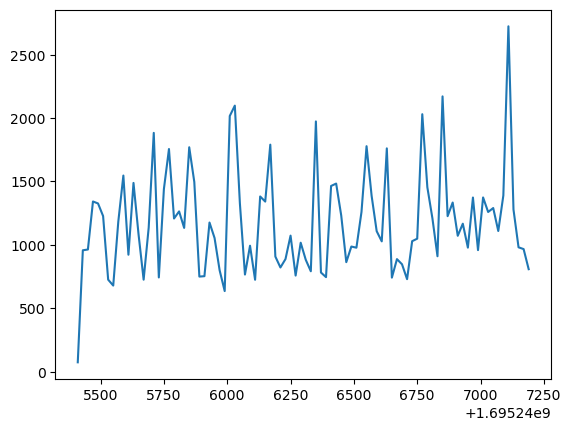

In [8]:
plt.plot(output1['time'], output1['vel_rayleigh_all'])

In [9]:
output1['time']

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       UTCDateTime(2023, 9, 20, 21, 30, 10),
       UTCDateTime(2023, 9, 20, 21, 30, 30),
       UTCDateTime(2023, 9, 20, 21, 30, 50),
       UTCDateTime(2023, 9, 20, 21, 31, 10),
       UTCDateTime(2023, 9, 20, 21, 31, 30),
       UTCDateTime(2023, 9, 20, 21, 31, 50),
       UTCDateTime(2023, 9, 20, 21, 32, 10),
       UTCDateTime(2023, 9, 20, 21, 32, 30),
       UTCDateTime(2023, 9, 20, 21, 32, 50),
       UTCDateTime(2023, 9, 20, 21, 33, 10),
       UTCDateTime(2023, 9, 20, 21, 33, 30),
      